In [15]:
%matplotlib inline
import networkx as nx
import metis
import random
from tqdm import tqdm
from itertools import chain
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import pandas as pd

In [2]:
GAMMA = 1.5

In [3]:
def get_alpha(g, k=2, gamma=GAMMA):
    return np.sqrt(k) * g.number_of_edges() / np.power(g.number_of_nodes(), GAMMA)

In [4]:
def attempt_reassignment(g, n, partition, node2cluster, gamma, alpha):    
    c_star = best_cluster_id(g, n, partition, gamma, alpha)
    did_it = False
    if node2cluster[n] != c_star:
        partition[node2cluster[n]].remove(n)
        partition[c_star].add(n)
        node2cluster[n] = c_star
        did_it = True
    return did_it, partition, node2cluster

def best_cluster_id(g, u, part, gamma, alpha):
    """part: dict(cluster_id, set of node)
             the partition information
        alpha, gamma: balancing parameter"""
    N_u = set(g.neighbors(u))
    def score(c):
        s = (len(part[c].intersection(N_u)) -
                alpha * gamma / 2 * np.power(len(part[c]), gamma-1))
        return s
    return max(part, key=score)

In [5]:
def update_partition(g, node_cluster_ids, k=2,
                     edges_to_add=[], edges_to_remove=[],
                     gamma=GAMMA,
                     verbose=True):
    """
    incrementally update the partitioning

    node_cluster_ids: list of cluster ids
    
    return:
        list of updated cluster ids
    """
    if len(edges_to_add) == 0 and len(edges_to_remove) == 0:
        print('nothing to update')
        return node_cluster_ids
    
    partition = defaultdict(set)  # cluster id to list of nodes
    for p, n in zip(node_cluster_ids, g.nodes_iter()):
        partition[p].add(n)
    node2cluster = dict(zip(g.nodes(), node_cluster_ids))  # node to cluster id
    
    # print(node2cluster)
    g.add_edges_from(edges_to_add)
    g.remove_edges_from(edges_to_remove)

    alpha = get_alpha(g, gamma=gamma)
    params = {'gamma': gamma, 'alpha': alpha}
    edge_iters = chain(edges_to_add, edges_to_remove)
    if verbose:
        iters = tqdm(edge_iters)

    for u, v in edge_iters:
        if verbose:
            print('edge ({}, {})'.format(u, v))
        affected_nodes = set()
        did_it, partition, node2cluster = attempt_reassignment(g, u,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(u))
            affected_nodes |= set(g.neighbors(u))
        did_it, partition, node2cluster = attempt_reassignment(g, v,
                                                               partition,
                                                               node2cluster,
                                                               **params)
        if did_it:
            if verbose:
                print('moved node {}'.format(v))
            affected_nodes |= set(g.neighbors(v))

        for n in affected_nodes:
            if True:
                did_it, partition, node2cluster = attempt_reassignment(
                    g, n, partition, node2cluster, **params)
                if verbose:
                    if did_it:
                        print('moved node {}'.format(n))      
                    else:
                        print('{} stayed'.format(n))

    return [node2cluster[n] for n in g.nodes_iter()]

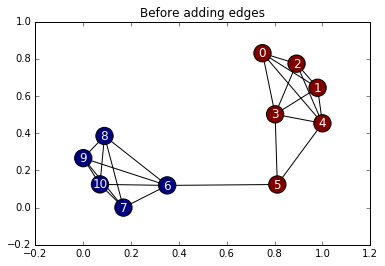

In [6]:
g = nx.barbell_graph(5, 1)
g.add_edge(3, 5)

_, part = metis.part_graph(g, 2)

nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('Before adding edges')

0it [00:00, ?it/s]

edge (5, 7)
moved node 5
8 stayed
3 stayed
4 stayed
6 stayed
7 stayed
edge (5, 8)


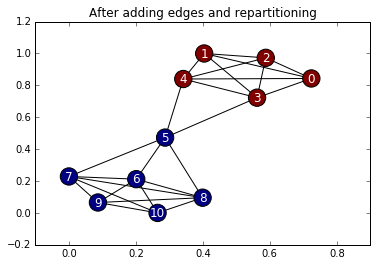

In [7]:
part = update_partition(g, node_cluster_ids=part, edges_to_add=[(5, 7), (5, 8)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After adding edges and repartitioning')

0it [00:00, ?it/s]

edge (5, 7)
moved node 5
3 stayed
4 stayed
6 stayed
edge (5, 8)


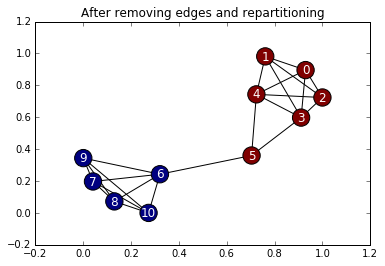

In [8]:
part = update_partition(g, node_cluster_ids=part, edges_to_remove=[(5, 7), (5, 8)])
nx.draw_networkx(g, font_color='white', node_color=part)
plt.title('After removing edges and repartitioning')

In [18]:
def performance(g, updated_cluster_ids, raw_cuts, raw_cluster_ids):
    partition = defaultdict(set)
    for n, c in zip(g.nodes_iter(), updated_cluster_ids):
        partition[c].add(n)

    c1, c2 = list(partition.values())
    cuts = 0.0
    for u, v in tqdm(g.edges_iter()):
        if (u in c1 and v in c2) or (u in c2 and v in c1):
            cuts += 1
    r1 = cuts / g.number_of_edges()
    size_1 = (len(c1), len(c2))
    
    r2 = raw_cuts / g.number_of_edges()     
    size_2 = tuple(Counter(raw_cluster_ids).values())
    return {'cut_ratio_1': r1, 
            'cut_ratio_2': r2,
            'size_1': size_1,
            'size_2': size_2}

In [10]:
cuts, raw_parts = metis.part_graph(g, 2)
performance(g, part, cuts, raw_parts)

23it [00:00, 191406.73it/s]


{'cut_ratio_1': 0.043478260869565216,
 'cut_ratio_2': 0.043478260869565216,
 'size_1': (5, 6),
 'size_2': (5, 6)}

In [11]:
def sample_edges_to_add(g, n_edges_to_add):
    n = 0
    edges_to_add = []
    nodes = g.nodes()
    while n < n_edges_to_add:
        while True:
            u = v = random.choice(nodes)
            while u == v:
                v = random.choice(nodes)
            if not g.has_edge(u, v):
                edges_to_add.append((u, v))
                break
        n += 1
    return edges_to_add                

In [12]:
# test
assert len(sample_edges_to_add(g, 10)) == 10
for e in sample_edges_to_add(g, 10):
    assert not g.has_edge(*e)

In [30]:
# Experiment on real networks
from glob import glob
from time import time


add_edges_percent = 0.1
remove_edges_percent = 0.1

rows = []
for path in tqdm(glob('data/*.gpkl')):
    name = os.path.basename(path).split('.')[0]
    print(name)
    g = nx.read_gpickle(path)
    _, parts = metis.part_graph(g, 2)
    
    edges_to_remove = random.sample(g.edges(), int(g.number_of_edges() * remove_edges_percent))
    edges_to_add = sample_edges_to_add(g, int(g.number_of_edges() * add_edges_percent))

    s = time()
    
    updated_parts = update_partition(g, 
                                     node_cluster_ids=parts,
                                     edges_to_add=edges_to_add,
                                     edges_to_remove=edges_to_remove,
                                     verbose=False)
    takes_time_1 = time() - s
    
    s = time()
    raw_cuts, raw_parts = metis.part_graph(g, 2)
    takes_time_2 = time() - s
    
    stat = performance(g, updated_parts, raw_cuts, raw_parts)
    stat['name'] = name
    stat['running_time_1'] = takes_time_1
    stat['running_time_2'] = takes_time_2
    rows.append(stat)

  0%|          | 0/8 [00:00<?, ?it/s]

circular



0it [00:00, ?it/s]
 12%|█▎        | 1/8 [00:03<00:22,  3.16s/it]

barbell_1000_0



0it [00:00, ?it/s]
144045it [00:00, 1425490.57it/s]
281180it [00:00, 1408802.10it/s]
417403it [00:00, 1394496.84it/s]
536111it [00:00, 1320785.67it/s]
677966it [00:00, 1348667.78it/s]
821274it [00:00, 1372927.96it/s]
952216it [00:00, 1353237.41it/s]
 25%|██▌       | 2/8 [01:12<02:18, 23.14s/it]

mtvhottest



0it [00:00, ?it/s]
70631it [00:00, 706308.99it/s]
 38%|███▊      | 3/8 [01:24<01:38, 19.75s/it]

star



0it [00:00, ?it/s]
 50%|█████     | 4/8 [02:14<01:55, 28.78s/it]

beefban



0it [00:00, ?it/s]
 62%|██████▎   | 5/8 [02:17<01:03, 21.08s/it]

baltimore



0it [00:00, ?it/s]
66912it [00:00, 669114.26it/s]
118468it [00:00, 614208.67it/s]
 75%|███████▌  | 6/8 [02:30<00:37, 18.74s/it]

ukraine



0it [00:00, ?it/s]
68244it [00:00, 682435.77it/s]
 88%|████████▊ | 7/8 [02:38<00:15, 15.24s/it]

barabasi



0it [00:00, ?it/s]
57306it [00:00, 573056.45it/s]
116290it [00:00, 577990.12it/s]
100%|██████████| 8/8 [02:44<00:00, 12.73s/it]


In [31]:
df = pd.DataFrame.from_records(rows)

In [32]:
df.head(2)

,cut_ratio_1,cut_ratio_2,name,running_time_1,running_time_2,size_1,size_2
0,0.045920,0.009440,circular,0.681479,0.986356,"(25001, 24999)","(24999, 25001)"
1,0.095585,0.095585,barbell_1000_0,58.217181,4.451923,"(1000, 1000)","(1000, 1000)"


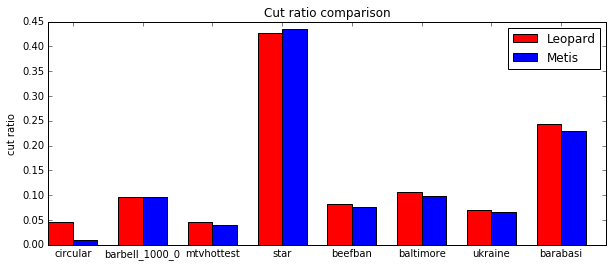

In [49]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['cut_ratio_1'], width, color='red')
ax.bar(ind+width, df['cut_ratio_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('cut ratio')
ax.set_title('Cut ratio comparison')
fig.set_figwidth(10)
ax.legend(['Leopard', 'Metis'])

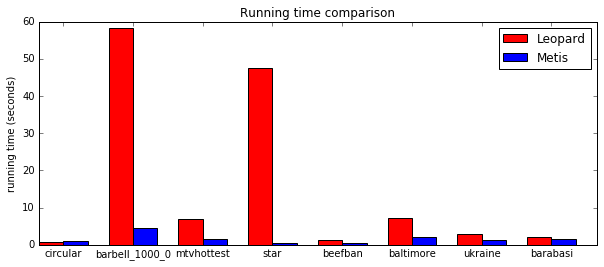

In [50]:
# cut ratio
fig, ax = plt.subplots()

N = df.shape[0]
ind = np.arange(N)
width = 0.35

ax.bar(ind, df['running_time_1'], width, color='red')
ax.bar(ind+width, df['running_time_2'], width, color='blue')

ax.set_xticks(ind + width)
ax.set_xticklabels(df['name'])
ax.set_ylabel('running time (seconds)')
ax.set_title('Running time comparison')
fig.set_figwidth(10)
ax.legend(['Leopard', 'Metis'])